In [1]:
from zipfile import ZipFile
import pandas as pd

zip_file = ZipFile("/content/data/jena_climate_2009_2016.csv.zip")

with zip_file.open("jena_climate_2009_2016.csv") as zf:
    df = pd.read_csv(zf)

In [2]:
#Trabalhamos com horas
df=df[5::6]

In [3]:
#Retirar coluna alvo e armazenar em uma variável separada
y=df['T (degC)'].values
df=df.drop(columns=['T (degC)'])

In [4]:
#Transformar em numpy
import numpy as np

X=np.zeros((len(df),13))
for i in range(len(df)):
    cols=df.iloc[i]
    for j in range(13):
        X[i][j]=cols[j+1]

In [5]:
X.shape,y.shape

((70091, 13), (70091,))

# Modelagem

Nesta seção fazemos os experimentos para prever  a variável alvo utilizando os sinais disponibilizados

## Macro

Para esta seção consideramos segmentos grande de tempo(macro) para predicao. Em um caso utilizamos metade da série temporal para treino e validação, e tentamos prever a outra metade.

### Metade

#### Modelos Baseline

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
from darts import TimeSeries

In [8]:
xseries=TimeSeries.from_values(y[:])

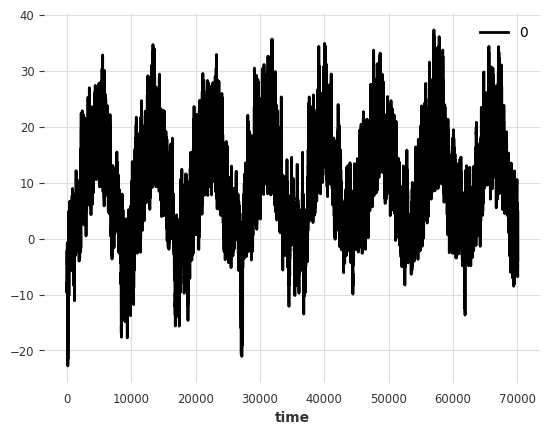

In [9]:
xseries.plot()

In [10]:
len(xseries)

70091

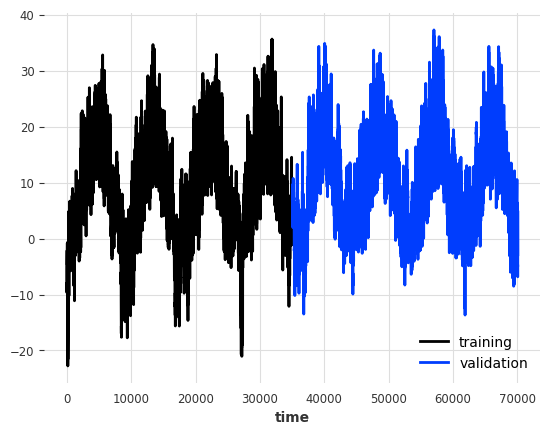

In [11]:
# train, val = xseries[:len(xseries)//2],xseries[len(xseries)//2:]
forecast_len=len(xseries)//2
train, val = xseries[:len(xseries)//2],xseries[len(xseries)//2:forecast_len+len(xseries)//2]
train.plot(label="training")
val.plot(label="validation")

/opt/conda/lib/python3.10/site-packages/statsforecast/core.py:17: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
Support for Torch based models not available. To enable them, install "darts", "u8darts[torch]" or "u8darts[all]" (with pip); or "u8darts-torch" or "u8darts-all" (with conda).


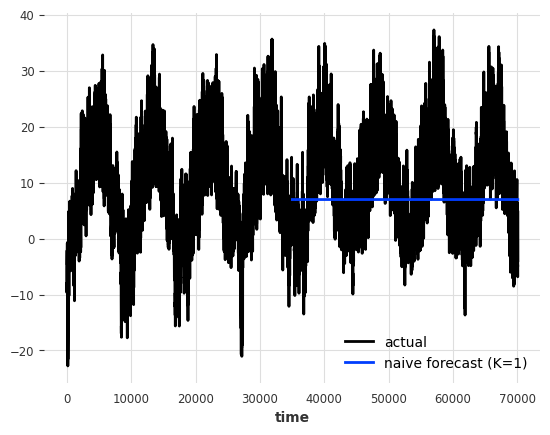

In [12]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(forecast_len)

xseries.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

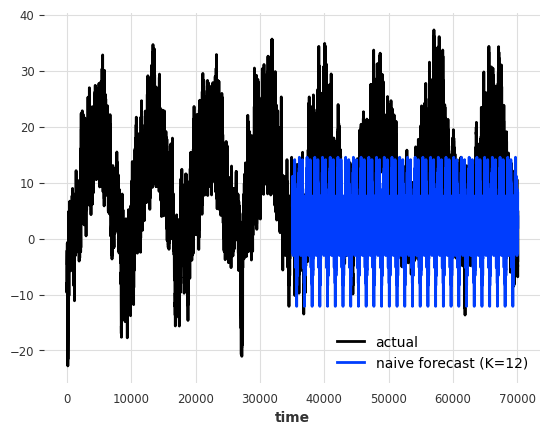

In [13]:
seasonal_model = NaiveSeasonal(K=1200)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(forecast_len)

xseries.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

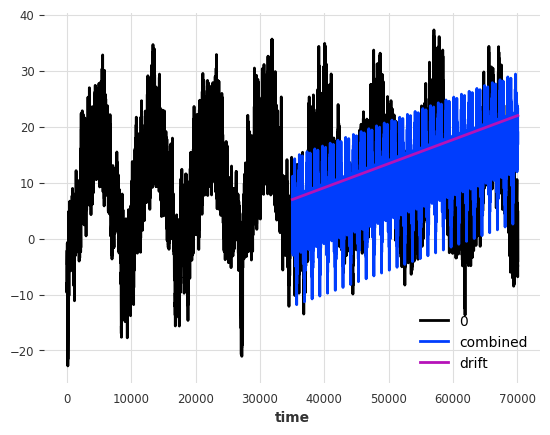

In [14]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(forecast_len)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

xseries.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [15]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta
from darts.metrics import mse,mae,rmse


#Baselines

model=ExponentialSmoothing()
model.fit(train)
forecast = model.predict(len(val))
print("model {} obtains MSE: {:.2f}%".format(model, mse(val, forecast)))
print("model {} obtains MAE: {:.2f}%".format(model, mae(val, forecast)))
print("model {} obtains RMSE: {:.2f}%".format(model, rmse(val, forecast)))


seasonal_model=NaiveSeasonal(K=1200)
seasonal_model.fit(train)
forecast = seasonal_model.predict(len(val))
print("model {} obtains MSE: {:.2f}%".format(seasonal_model, mse(val, forecast)))
print("model {} obtains MAE: {:.2f}%".format(seasonal_model, mae(val, forecast)))
print("model {} obtains RMSE: {:.2f}%".format(seasonal_model, rmse(val, forecast)))


drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(len(val))
combined_forecast = drift_forecast + seasonal_forecast - train.last_value()
print("model {} obtains MSE: {:.2f}%".format(drift_model, mse(val, combined_forecast)))
print("model {} obtains MAE: {:.2f}%".format(drift_model, mae(val, combined_forecast)))
print("model {} obtains RMSE: {:.2f}%".format(drift_model, rmse(val, combined_forecast)))

model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 obtains MSE: 62338823.73%
model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 obtains MAE: 6837.33%
model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 obtains RMSE: 7895.49%
model Naive seasonal model, with K=1200 obtains MSE: 137.54%
model Naive seasonal model, with K=1200 obtains MAE: 9.49%
model Naive seasonal model, with K=1200 obtains RMSE: 11.73%
model Naive drift model obtains MSE: 96.77%
model Naive drift model obtains MAE: 7.94%
model Naive drift model obtains RMSE: 9.84%


Melhor resultado e o Naive drift, com MSE 96.77e-01 MAE 7.94e-02 MAE 9.84e-02

#### Modelos regressão

Os modelos nessa seção consideram mais que somente o histórico da série temporal que queremos predizer. Eles levam em conta as demais variáveis temporais, como informação auxiliar na predição. Experimentamos com diversos modelos de regressão, e comparamos suas performances ao final.

In [16]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def train_regression(model,d,X_train,y_train,X_test,y_test):
    print('training...')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse=mean_squared_error(y_test, y_pred)
    mae=mean_absolute_error(y_test, y_pred)
    rmse=mean_squared_error(y_test, y_pred,squared=False)
    d['mse'].append(mse)
    d['mae'].append(mae)
    d['rmse'].append(rmse)
    return y_pred,d

In [17]:
# forecast_len=5000

In [18]:
d={'model':['RandomForestRegressor','LinearRegression',
            'XGBRegressor','BayesianRidge','SGDRegressor',
            'GradientBoostingRegressor','ElasticNet'
           ],'mse':[],'mae':[],'rmse':[]}
y_pred=train_regression(RandomForestRegressor(),d,X[:len(X)//2],y[:len(X)//2],X[len(X)//2:forecast_len+len(X)//2],y[len(X)//2:forecast_len+len(X)//2])
y_pred=train_regression(LinearRegression(),d,X[:len(X)//2],y[:len(X)//2],X[len(X)//2:forecast_len+len(X)//2],y[len(X)//2:forecast_len+len(X)//2])
y_pred=train_regression(XGBRegressor(),d,X[:len(X)//2],y[:len(X)//2],X[len(X)//2:forecast_len+len(X)//2],y[len(X)//2:forecast_len+len(X)//2])
y_pred=train_regression(BayesianRidge(),d,X[:len(X)//2],y[:len(X)//2],X[len(X)//2:forecast_len+len(X)//2],y[len(X)//2:forecast_len+len(X)//2])
y_pred=train_regression(SGDRegressor(),d,X[:len(X)//2],y[:len(X)//2],X[len(X)//2:forecast_len+len(X)//2],y[len(X)//2:forecast_len+len(X)//2])
y_pred=train_regression(GradientBoostingRegressor(),d,X[:len(X)//2],y[:len(X)//2],X[len(X)//2:forecast_len+len(X)//2],y[len(X)//2:forecast_len+len(X)//2])
y_pred=train_regression(ElasticNet(),d,X[:len(X)//2],y[:len(X)//2],X[len(X)//2:forecast_len+len(X)//2],y[len(X)//2:forecast_len+len(X)//2])

result=pd.DataFrame(d)
result

training...
training...
training...
training...
training...
training...
training...


,model,mse,mae,rmse
0,RandomForestRegressor,2.999581e-04,3.489648e-03,1.731930e-02
1,LinearRegression,1.925530e-03,7.186095e-03,4.388086e-02
2,XGBRegressor,9.846250e-04,2.083774e-02,3.137873e-02
3,BayesianRidge,1.925889e-03,7.186018e-03,4.388495e-02
4,SGDRegressor,1.580478e+29,3.952169e+14,3.975522e+14
5,GradientBoostingRegressor,6.933608e-03,6.259256e-02,8.326829e-02
6,ElasticNet,1.925694e-02,9.473746e-02,1.387694e-01


In [19]:
#Treinar o melhor modelo separadamente
y_pred,_=train_regression(RandomForestRegressor(),d,X[:len(X)//2],y[:len(X)//2],X[len(X)//2:forecast_len+len(X)//2],y[len(X)//2:forecast_len+len(X)//2])

training...


Predição do melhor modelo(Random Forest)

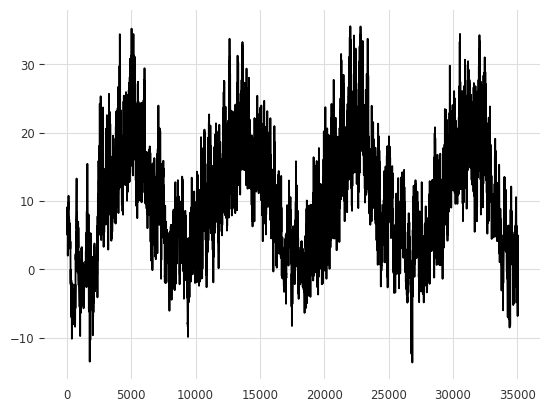

In [20]:
import matplotlib.pyplot as plt
import datetime
import numpy as np

x = np.array([i for i in range(len(y_pred))])
plt.plot(x,y_pred)
plt.show()

Valores reais da série no período de predição

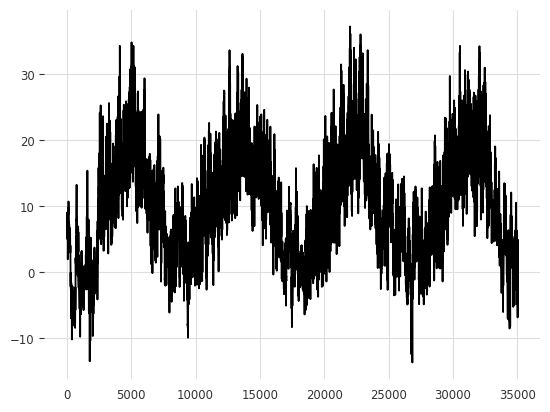

In [21]:
x = np.array([i for i in range(len(y[len(X)//2:forecast_len+len(X)//2]))])
plt.plot(x,y[len(X)//2:forecast_len+len(X)//2])
plt.show()

### 1 ano

In [ ]:
forecast_len=8766 #8766 horas=1 ano

#### Modelos Baseline

In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
from darts import TimeSeries

In [24]:
xseries=TimeSeries.from_values(y[:])

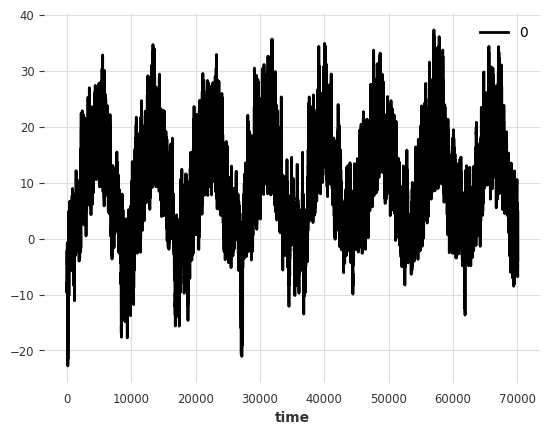

In [25]:
xseries.plot()

In [26]:
len(xseries)

70091

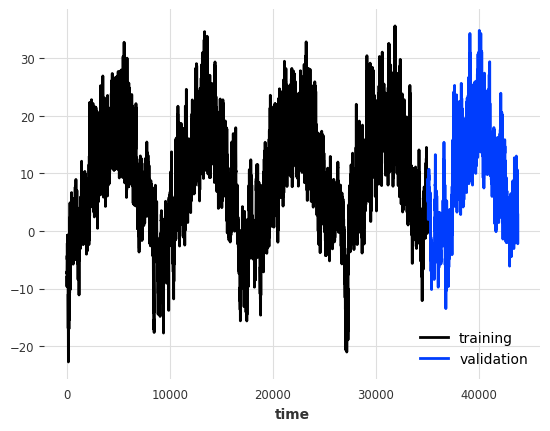

In [27]:
train, val = xseries[:len(xseries)//2],xseries[len(xseries)//2:forecast_len+len(xseries)//2]
train.plot(label="training")
val.plot(label="validation")

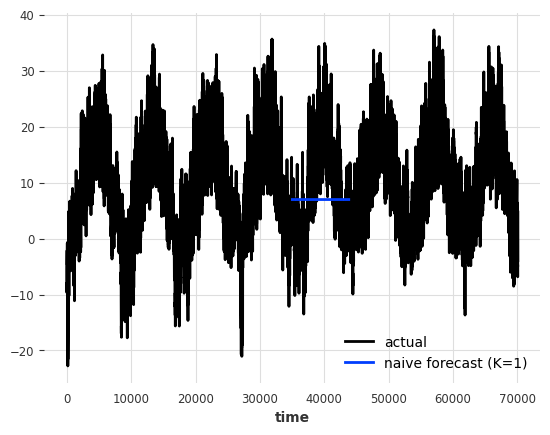

In [28]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(forecast_len)

xseries.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

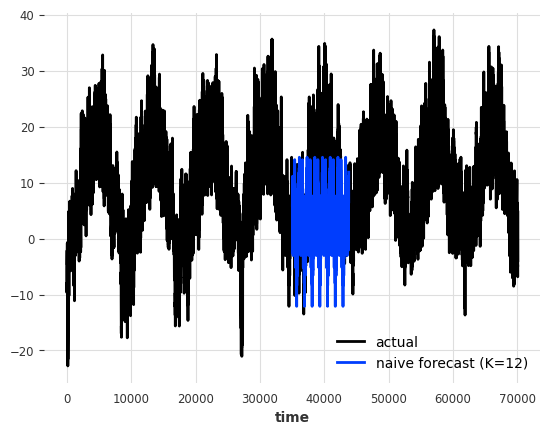

In [29]:
seasonal_model = NaiveSeasonal(K=1200)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(forecast_len)

xseries.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

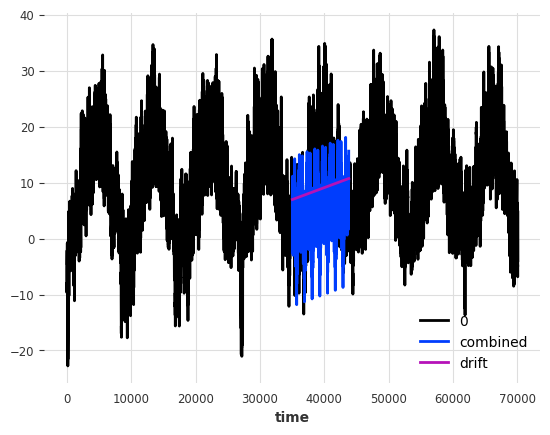

In [30]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(forecast_len)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

xseries.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [31]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta
from darts.metrics import mse,mae,rmse


#Baselines

model=ExponentialSmoothing()
model.fit(train)
forecast = model.predict(len(val))
print("model {} obtains MSE: {:.2f}%".format(model, mse(val, forecast)))
print("model {} obtains MAE: {:.2f}%".format(model, mae(val, forecast)))
print("model {} obtains RMSE: {:.2f}%".format(model, rmse(val, forecast)))


seasonal_model=NaiveSeasonal(K=1200)
seasonal_model.fit(train)
forecast = seasonal_model.predict(len(val))
print("model {} obtains MSE: {:.2f}%".format(seasonal_model, mse(val, forecast)))
print("model {} obtains MAE: {:.2f}%".format(seasonal_model, mae(val, forecast)))
print("model {} obtains RMSE: {:.2f}%".format(seasonal_model, rmse(val, forecast)))


drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(len(val))
combined_forecast = drift_forecast + seasonal_forecast - train.last_value()
print("model {} obtains MSE: {:.2f}%".format(drift_model, mse(val, combined_forecast)))
print("model {} obtains MAE: {:.2f}%".format(drift_model, mae(val, combined_forecast)))
print("model {} obtains RMSE: {:.2f}%".format(drift_model, rmse(val, combined_forecast)))

model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 obtains MSE: 3891947.77%
model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 obtains MAE: 1709.21%
model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 obtains RMSE: 1972.80%
model Naive seasonal model, with K=1200 obtains MSE: 124.65%
model Naive seasonal model, with K=1200 obtains MAE: 9.09%
model Naive seasonal model, with K=1200 obtains RMSE: 11.16%
model Naive drift model obtains MSE: 100.09%
model Naive drift model obtains MAE: 8.13%
model Naive drift model obtains RMSE: 10.00%


#### Modelos regressão

Os modelos nessa seção consideram mais que somente o histórico da série temporal que queremos predizer. Eles levam em conta as demais variáveis temporais, como informação auxiliar na predição. Experimentamos com diversos modelos de regressão, e comparamos suas performances ao final.

In [32]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def train_regression(model,d,X_train,y_train,X_test,y_test):
    print('training...')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse=mean_squared_error(y_test, y_pred)
    mae=mean_absolute_error(y_test, y_pred)
    rmse=mean_squared_error(y_test, y_pred,squared=False)
    d['mse'].append(mse)
    d['mae'].append(mae)
    d['rmse'].append(rmse)
    return y_pred,d

In [33]:
# forecast_len=5000

In [34]:
d={'model':['RandomForestRegressor','LinearRegression',
            'XGBRegressor','BayesianRidge','SGDRegressor',
            'GradientBoostingRegressor','ElasticNet'
           ],'mse':[],'mae':[],'rmse':[]}
y_pred=train_regression(RandomForestRegressor(),d,X[:len(X)//2],y[:len(X)//2],X[len(X)//2:forecast_len+len(X)//2],y[len(X)//2:forecast_len+len(X)//2])
y_pred=train_regression(LinearRegression(),d,X[:len(X)//2],y[:len(X)//2],X[len(X)//2:forecast_len+len(X)//2],y[len(X)//2:forecast_len+len(X)//2])
y_pred=train_regression(XGBRegressor(),d,X[:len(X)//2],y[:len(X)//2],X[len(X)//2:forecast_len+len(X)//2],y[len(X)//2:forecast_len+len(X)//2])
y_pred=train_regression(BayesianRidge(),d,X[:len(X)//2],y[:len(X)//2],X[len(X)//2:forecast_len+len(X)//2],y[len(X)//2:forecast_len+len(X)//2])
y_pred=train_regression(SGDRegressor(),d,X[:len(X)//2],y[:len(X)//2],X[len(X)//2:forecast_len+len(X)//2],y[len(X)//2:forecast_len+len(X)//2])
y_pred=train_regression(GradientBoostingRegressor(),d,X[:len(X)//2],y[:len(X)//2],X[len(X)//2:forecast_len+len(X)//2],y[len(X)//2:forecast_len+len(X)//2])
y_pred=train_regression(ElasticNet(),d,X[:len(X)//2],y[:len(X)//2],X[len(X)//2:forecast_len+len(X)//2],y[len(X)//2:forecast_len+len(X)//2])

result=pd.DataFrame(d)
result

training...
training...
training...
training...
training...
training...
training...


,model,mse,mae,rmse
0,RandomForestRegressor,1.026471e-04,3.715298e-03,1.013149e-02
1,LinearRegression,8.522076e-05,6.771717e-03,9.231509e-03
2,XGBRegressor,8.534876e-04,2.101955e-02,2.921451e-02
3,BayesianRidge,8.522181e-05,6.771721e-03,9.231566e-03
4,SGDRegressor,1.554295e+29,3.925527e+14,3.942455e+14
5,GradientBoostingRegressor,6.924812e-03,6.320425e-02,8.321546e-02
6,ElasticNet,2.026460e-02,9.882445e-02,1.423538e-01


In [35]:
#Treinar o melhor modelo separadamente
y_pred,_=train_regression(RandomForestRegressor(),d,X[:len(X)//2],y[:len(X)//2],X[len(X)//2:forecast_len+len(X)//2],y[len(X)//2:forecast_len+len(X)//2])

training...


Predição do melhor modelo(Random Forest)

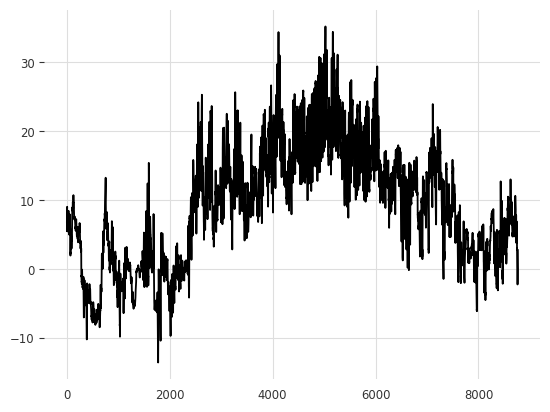

In [36]:
import matplotlib.pyplot as plt
import datetime
import numpy as np

x = np.array([i for i in range(len(y_pred))])
plt.plot(x,y_pred)
plt.show()

Valores reais da série no período de predição

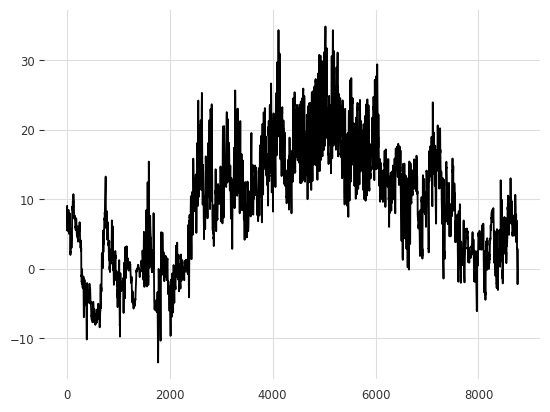

In [37]:
x = np.array([i for i in range(len(y[len(X)//2:forecast_len+len(X)//2]))])
plt.plot(x,y[len(X)//2:forecast_len+len(X)//2])
plt.show()

## Micro

Nesta seção consideramos a predição de períodos bem pequenos(2-10 horas). Para tal, criamos um dataset com amostras na seguinte forma: X(N horas) e y(10 horas seguintes)

#### N=30

In [38]:
#30 horas para prever as proximas 10 horas
N=30

In [39]:
seg_X=[]
seg_y=[]
c=0
c1=0
c2=0
sample=[]
sample_y=[]
while(c<X.shape[0]):
    if c1<N:
        sample.append(X[c])
        c1+=1
    else:
        sample_y.append(y[c])
        if len(sample_y)==10:
            c1=0
            c2=0
            seg_X.append(sample)
            seg_y.append(sample_y)
            sample=[]
            sample_y=[]
        c2+=1
    c+=1

In [40]:
seg_X=np.asarray(seg_X)
seg_y=np.asarray(seg_y)
seg_X=seg_X.reshape((seg_X.shape[0],seg_X.shape[1]*seg_X.shape[2]))

seg_X.shape,seg_y.shape

((1752, 390), (1752, 10))

In [41]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    seg_X, seg_y, test_size=0.33, random_state=42)

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def train_regression(model,d,X_train,y_train,X_test,y_test):
    print('training...')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse=mean_squared_error(y_test, y_pred)
    mae=mean_absolute_error(y_test, y_pred)
    rmse=mean_squared_error(y_test, y_pred,squared=False)
    d['mse'].append(mse)
    d['mae'].append(mae)
    d['rmse'].append(rmse)
    return y_pred,d

In [43]:
d={'model':['RandomForestRegressor','LinearRegression',
            'XGBRegressor','ElasticNet'
           ],'mse':[],'mae':[],'rmse':[]}
y_pred=train_regression(RandomForestRegressor(),d,X_train,y_train,X_test,y_test)
y_pred=train_regression(LinearRegression(),d,X_train,y_train,X_test,y_test)
y_pred=train_regression(XGBRegressor(),d,X_train,y_train,X_test,y_test)
y_pred=train_regression(ElasticNet(),d,X_train,y_train,X_test,y_test)

result=pd.DataFrame(d)
result

training...
training...
training...
training...


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.370e+01, tolerance: 8.058e+00
  model = cd_fast.enet_coordinate_descent(


,model,mse,mae,rmse
0,RandomForestRegressor,5.504239,1.710894,2.285439
1,LinearRegression,5061.622552,4.120607,53.711515
2,XGBRegressor,5.801520,1.768418,2.320124
3,ElasticNet,4.978014,1.618254,2.132799


In [44]:
y_pred,_=train_regression(ElasticNet(),d,X_train,y_train,X_test,y_test)

training...


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.370e+01, tolerance: 8.058e+00
  model = cd_fast.enet_coordinate_descent(


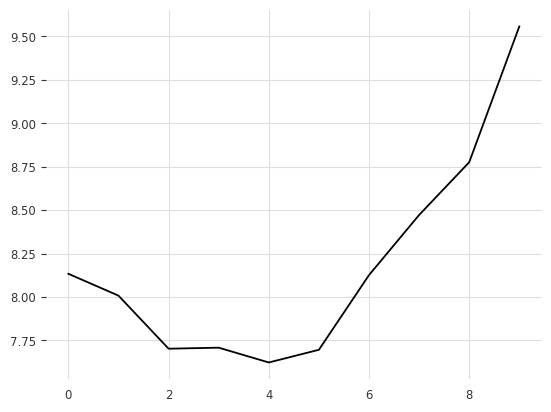

In [45]:
import matplotlib.pyplot as plt
import datetime
import numpy as np

i=100

x = np.array([i for i in range(len(y_pred[i]))])
plt.plot(x,y_pred[i])
plt.show()

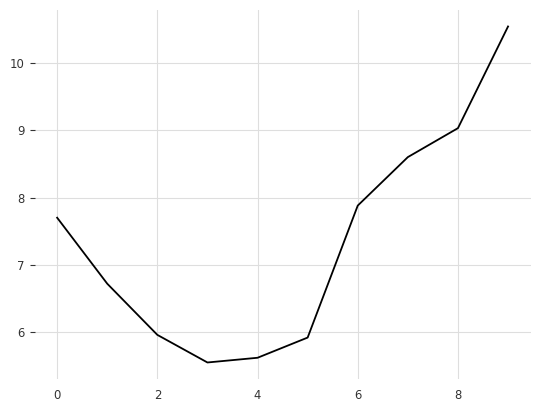

In [46]:
import matplotlib.pyplot as plt
import datetime
import numpy as np

x = np.array([i for i in range(len(y_test[i]))])
plt.plot(x,y_test[i])
plt.show()

#### N=100

In [47]:
#100 horas para prever as proximas 10 horas
N=100

In [48]:
seg_X=[]
seg_y=[]
c=0
c1=0
c2=0
sample=[]
sample_y=[]
while(c<X.shape[0]):
    if c1<N:
        sample.append(X[c])
        c1+=1
    else:
        sample_y.append(y[c])
        if len(sample_y)==10:
            c1=0
            c2=0
            seg_X.append(sample)
            seg_y.append(sample_y)
            sample=[]
            sample_y=[]
        c2+=1
    c+=1

In [49]:
seg_X=np.asarray(seg_X)
seg_y=np.asarray(seg_y)
seg_X=seg_X.reshape((seg_X.shape[0],seg_X.shape[1]*seg_X.shape[2]))

seg_X.shape,seg_y.shape

((637, 1300), (637, 10))

In [50]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    seg_X, seg_y, test_size=0.33, random_state=42)

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def train_regression(model,d,X_train,y_train,X_test,y_test):
    print('training...')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse=mean_squared_error(y_test, y_pred)
    mae=mean_absolute_error(y_test, y_pred)
    rmse=mean_squared_error(y_test, y_pred,squared=False)
    d['mse'].append(mse)
    d['mae'].append(mae)
    d['rmse'].append(rmse)
    return y_pred,d

In [52]:
d={'model':['RandomForestRegressor','LinearRegression',
            'XGBRegressor','ElasticNet'
           ],'mse':[],'mae':[],'rmse':[]}
y_pred=train_regression(RandomForestRegressor(),d,X_train,y_train,X_test,y_test)
y_pred=train_regression(LinearRegression(),d,X_train,y_train,X_test,y_test)
y_pred=train_regression(XGBRegressor(),d,X_train,y_train,X_test,y_test)
y_pred=train_regression(ElasticNet(),d,X_train,y_train,X_test,y_test)

result=pd.DataFrame(d)
result

training...
training...
training...
training...


,model,mse,mae,rmse
0,RandomForestRegressor,6.770105,1.985875,2.551893
1,LinearRegression,20.756329,3.467248,4.319815
2,XGBRegressor,7.781503,2.103661,2.696893
3,ElasticNet,6.055919,1.801075,2.340201


In [53]:
y_pred,_=train_regression(ElasticNet(),d,X_train,y_train,X_test,y_test)

training...


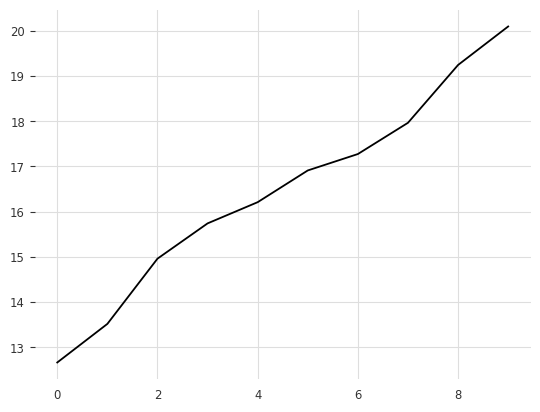

In [54]:
import matplotlib.pyplot as plt
import datetime
import numpy as np

i=100

x = np.array([i for i in range(len(y_pred[i]))])
plt.plot(x,y_pred[i])
plt.show()

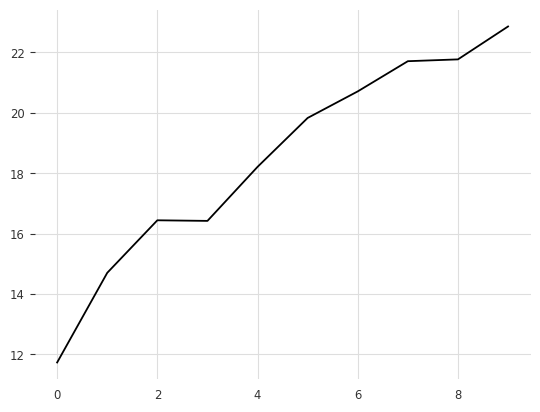

In [55]:
import matplotlib.pyplot as plt
import datetime
import numpy as np

x = np.array([i for i in range(len(y_test[i]))])
plt.plot(x,y_test[i])
plt.show()